In [27]:
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, LazyLinear, Linear, Conv2d, MaxPool2d, ReLU 
from torch.nn.init import xavier_normal_, zeros_, calculate_gain

import torchvision
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import v2

from lightning import LightningModule, LightningDataModule, Trainer, seed_everything
seed_everything(42);

import torchmetrics

from captum.attr import Saliency, IntegratedGradients, visualization

from typing import Callable
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS

Seed set to 42


In [9]:
CIFAR_PATH = Path.home() / "datasets" / "cifar"
CIFAR_PATH.mkdir(exist_ok=True)

LOGS_PATH = Path.cwd() / "logs"
if LOGS_PATH.is_dir():
    shutil.rmtree(LOGS_PATH.as_posix())
LOGS_PATH.mkdir()

SAVED_CKPT_PATH = Path.cwd() / "saved_models" / "save.ckpt"

In [10]:

class CifarDataModule(LightningDataModule):
    def __init__(self, root: Path, transform: Callable | None = None, num_classes: int = 10):
        super().__init__()
        self.root = root
        self.root.mkdir(exist_ok=True)
        self.transform = transform

        assert num_classes in (10, 100), "Pick from CIFAR10 or CIFAR100"
        if num_classes == 10:
            self.cifar = CIFAR10
        elif num_classes == 100:
            self.cifar = CIFAR100
    
    def prepare_data(self):
        #TODO: Check for Cifar-100-batches if num_classes = 100
        if "cifar-10-batches-py" not in [x.stem for x in self.root.iterdir()]:
            self.cifar(root = self.root, download = True) #type: ignore
        else:
            print(f"Dataset Found At: {self.root}")
    
    def setup(self, stage):
        assert stage in ("fit", "validate", "test", "predict")

        if stage == "fit":
            self.train_dataset = self.cifar(root = self.root, #type: ignore
                                            train = True, 
                                            transform = self.transform)
        
        self.val_dataset = self.cifar(root = self.root, #type: ignore
                                      train = False,
                                      transform = self.transform)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(dataset=self.train_dataset, 
                          batch_size=128,
                          shuffle=True,
                          num_workers=8)        
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(dataset=self.val_dataset, 
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(dataset=self.val_dataset, 
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

    def predict_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(dataset=self.val_dataset, 
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [11]:
class ConvNet(Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = Sequential(
            Conv2d(3, 6, 5),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(6, 16, 5),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.classifier = Sequential(
            Linear(16 * 5 * 5, 1024),
            ReLU(),
            Linear(1024, 1024),
            ReLU(),
            Linear(1024, num_classes)
        )

        self.weights_init()
   
    def forward(self, x) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1, -1)
        x = self.classifier(x)
        return x

    def weights_init(self) -> None:
        for module in self.modules():
            if isinstance(module, (Conv2d, Linear)):
                xavier_normal_(module.weight, calculate_gain("relu"))
                if module.bias is not None:
                    zeros_(module.bias)

In [12]:
class ImageClassifier(LightningModule):
    def __init__(self, model: Module, lr: float = 1e-3, momentum: float = 0.0, weight_decay: float = 0.0, num_classes: int = 10):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.num_classes = num_classes

        self._set_metrics()
        self.save_hyperparameters(ignore = ["model", "optimizer"])
   
    def forward(self, batch):
        x, _ = batch
        return self.model(x)

    def _forward_pass(self, batch, metrics : Callable | None = None) -> tuple:
        x, y = batch
        y_pred = self.model(x)
        if metrics:
            metrics.update(y_pred, y) 
        return self.criterion(y_pred, y), y_pred #type: ignore

    def _set_metrics(self):
        metrics = {"accuracy": torchmetrics.Accuracy(
                                task="multiclass",
                                num_classes=self.num_classes, 
                                average="macro"),

                   "f1" : torchmetrics.F1Score(
                                task="multiclass",
                                num_classes=self.num_classes,
                                average="macro")
                  }

        self.val_metrics = torchmetrics.MetricCollection(
            metrics=metrics.copy(), prefix = "val_"
        )
        self.test_metrics = torchmetrics.MetricCollection(
            metrics=metrics.copy(), prefix = "test_"
        )
        self.test_confm = torchmetrics.ConfusionMatrix(
            task = "multiclass", num_classes = self.num_classes,
        )

    def training_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch, self.val_metrics) 
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        self.log_dict(self.val_metrics, on_epoch=True, on_step=False) 
    
    def test_step(self, batch, batch_idx):
        _, y = batch
        _, y_pred = self._forward_pass(batch)
        self.test_metrics.update(y_pred, y)
        self.test_confm.update(y_pred, y)
    
    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

        self.test_confm.compute()
        self.test_confm.plot();
        plt.show()
        self.test_confm.reset()
        plt.clf();

    def configure_optimizers(self):
        return self.optimizer(params = self.model.parameters(),
                              lr = self.lr, momentum=self.momentum, 
                              weight_decay = self.weight_decay)

In [13]:
cifar_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize((.5, .5, .5), (.5, .5, .5))
]) 
cifar_inverse_transform = v2.Compose([
    v2.Normalize((-1, -1, -1), (2, 2, 2))
])

model = ConvNet(num_classes=10)
dm = CifarDataModule(CIFAR_PATH, cifar_transform)

In [14]:
trainer = Trainer(
    max_epochs=10,
    default_root_dir=LOGS_PATH
)
#trainer.fit(
    #model = ImageClassifier(model = model, lr = 1e-5, momentum = 0.9, weight_decay = 3e-4),
    #datamodule = dm 
#)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: /home/sambhav/dev/metacognition/src/interpretation/logs/lightning_logs


Dataset Found At: /home/sambhav/datasets/cifar


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

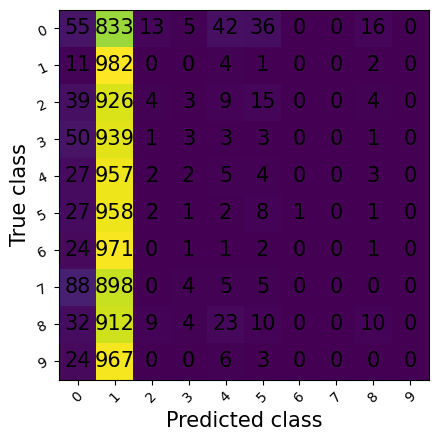

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.10669999569654465    │
│          test_f1          │    0.03264733776450157    │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.10669999569654465, 'test_f1': 0.03264733776450157}]

<Figure size 640x480 with 0 Axes>

In [15]:
trainer.test(
    model = ImageClassifier(model = model),
    datamodule = dm 
)

In [16]:
ckpt_state_dict = torch.load(SAVED_CKPT_PATH)["state_dict"]
state_dict = {key.removeprefix("model.") : ckpt_state_dict[key] for key in ckpt_state_dict.keys() if "criterion" not in key}
model = ConvNet(10)
model.load_state_dict(state_dict)
model.eval();

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


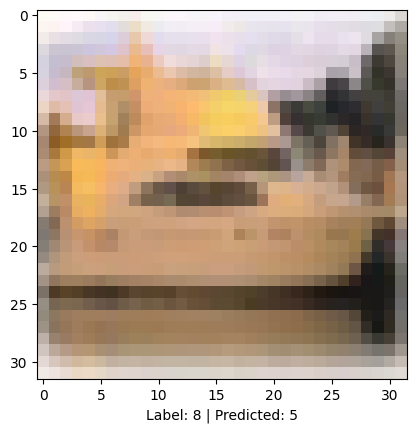

In [36]:
dm.setup("validate")
ds = dm.val_dataset

idx = int(torch.randint(0, int(1e4), (1,)).item())
image_t, label = ds.__getitem__(idx)
print(image_t.shape)
image = np.transpose(cifar_inverse_transform(image_t).cpu().detach().numpy(), (1, 2, 0))

image_t = image_t.unsqueeze(0)
image_t.requires_grad = True
print(image_t.shape)
pred = model(image_t).argmax().item()

plt.imshow(image)
plt.xlabel(f"Label: {label} | Predicted: {pred}")
plt.show()


(32, 32, 3)


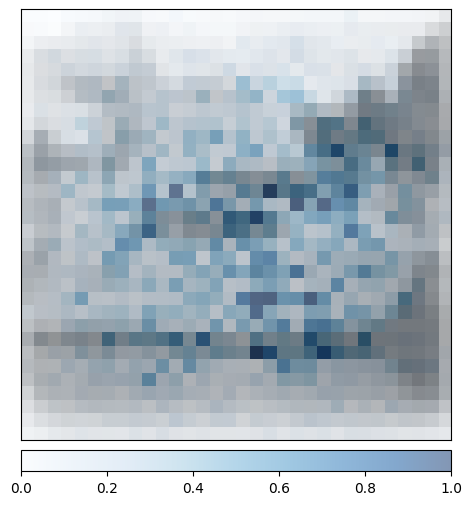

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [37]:
saliency = Saliency(model)
grads = saliency.attribute(image_t, target = label)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
print(grads.shape)
visualization.visualize_image_attr(grads, image, method="blended_heat_map", show_colorbar=True)

Approximation delta:  tensor([0.0010], dtype=torch.float64)


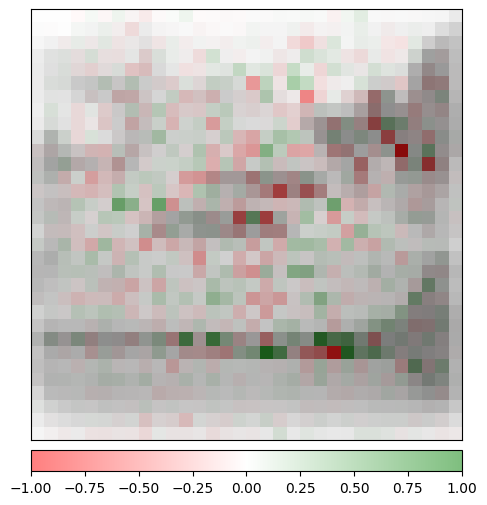

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [38]:
ig = IntegratedGradients(model)
attr_ig, delta = ig.attribute(inputs = image_t, baselines=torch.zeros_like(image_t), target = label, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

visualization.visualize_image_attr(attr=attr_ig,
                                   original_image=image,
                                   method="blended_heat_map",
                                   sign="all",
                                   show_colorbar=True)